In [2]:
!pip uninstall -y box2d-py
!pip install -U box2d==2.3.10 swig gymnasium[box2d]
!pip install swig
!pip install "gymnasium[box2d]"


  Using cached box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl


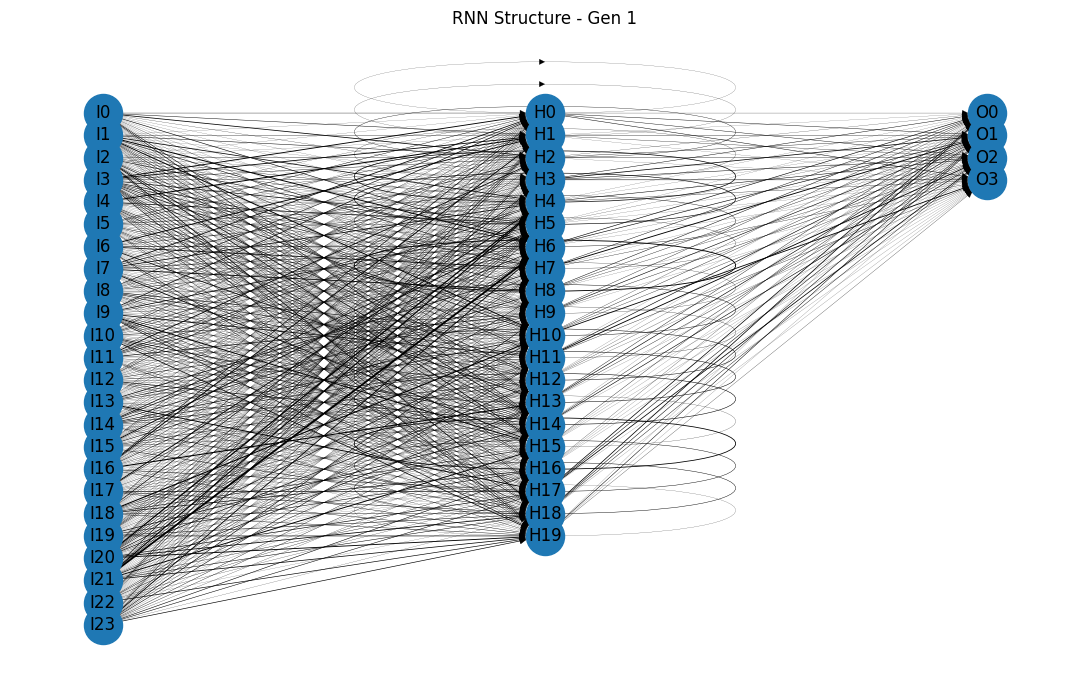

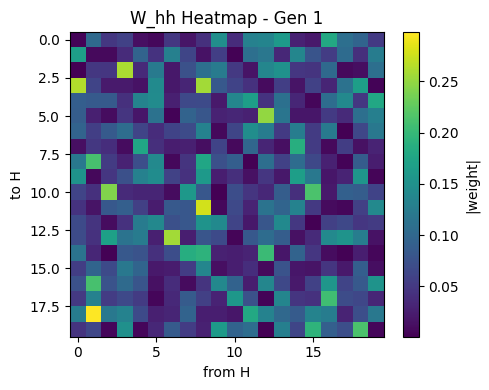

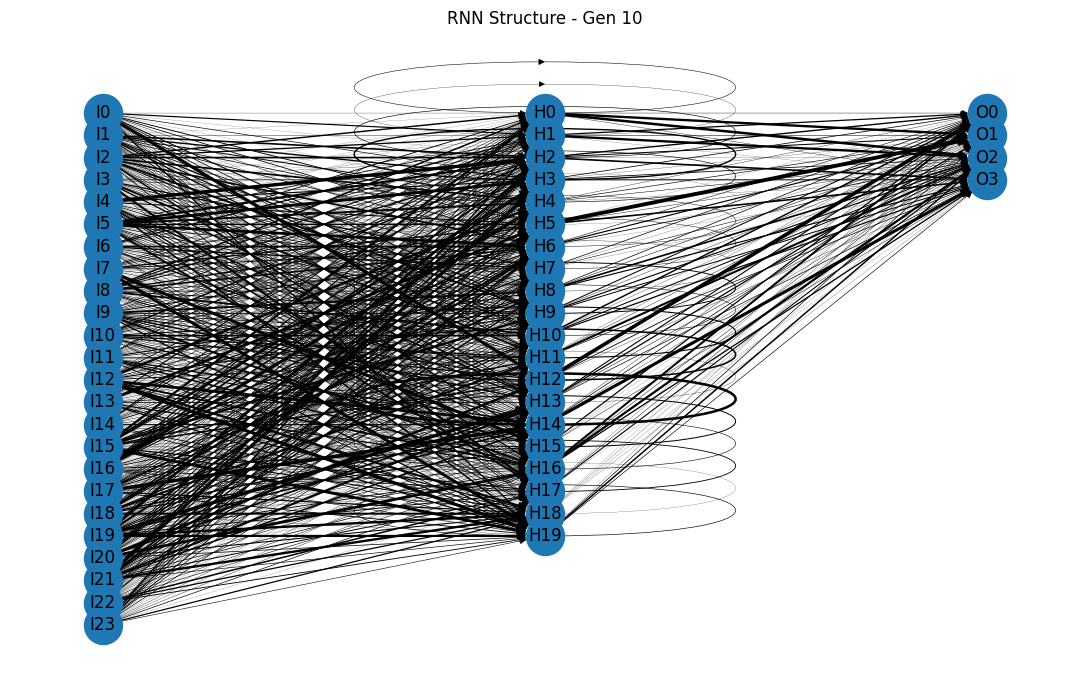

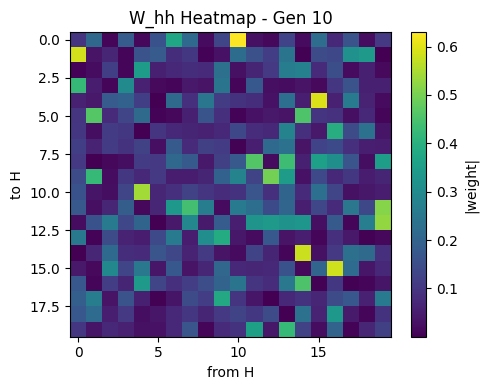

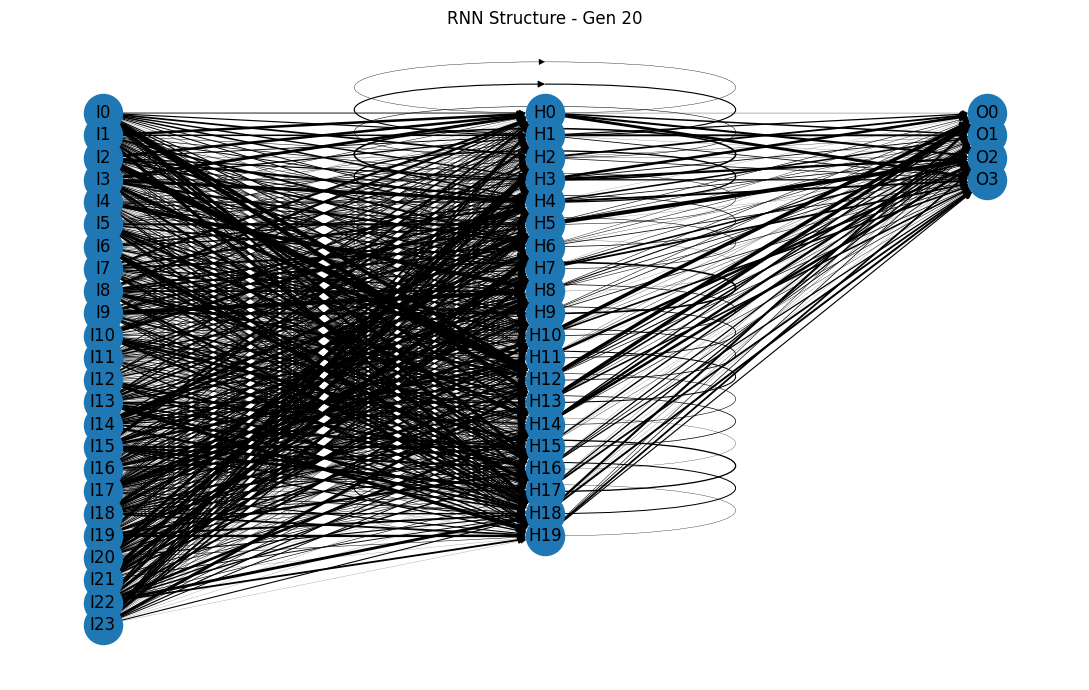

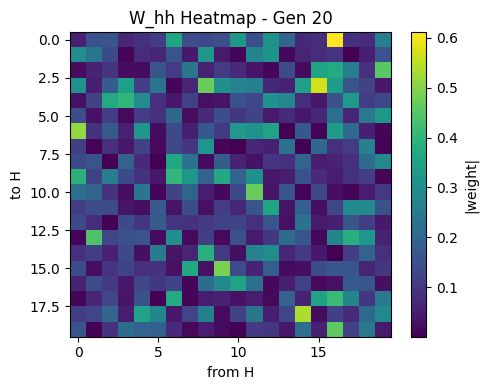

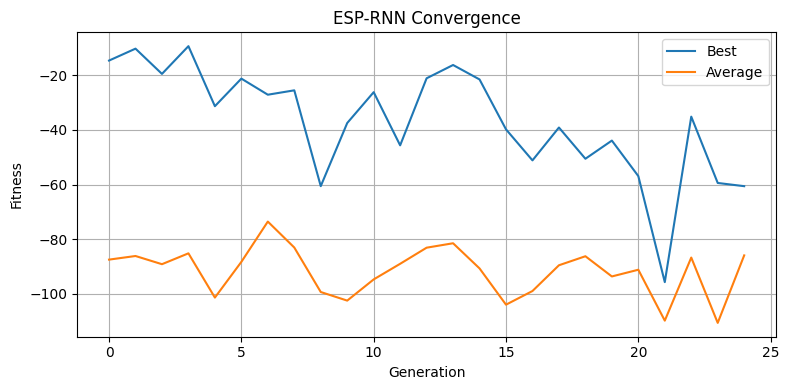

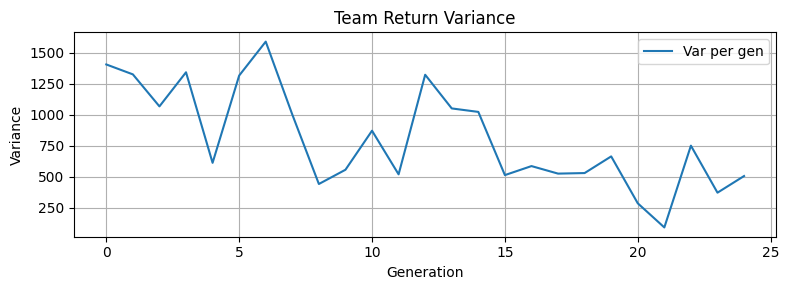

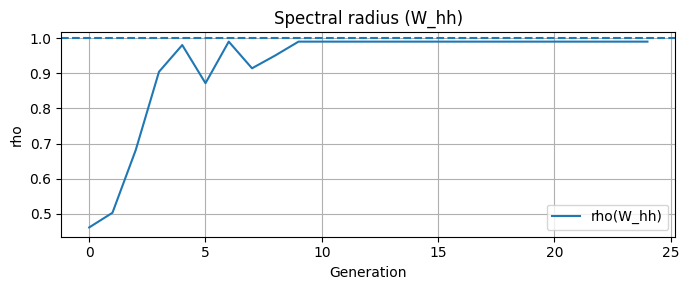

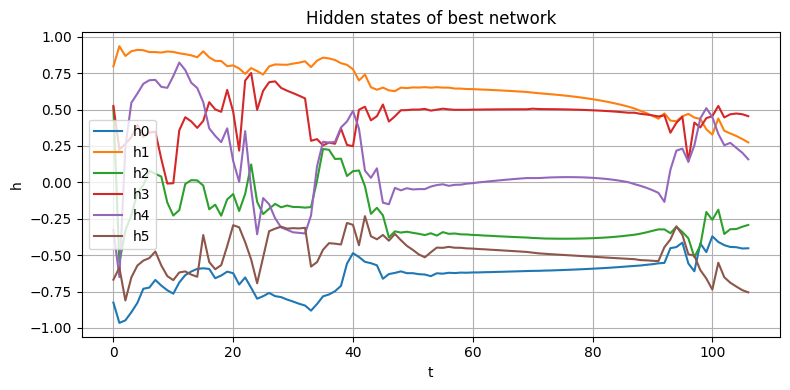

Saved: {"best_model": "esp_rnn_best.npz", "state": "esp_state.pkl"}


In [8]:
import argparse
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import gymnasium as gym
from typing import Tuple, List, Dict, Any


def spectral_radius(W: np.ndarray) -> float:
    vals = np.linalg.eigvals(W)
    return float(np.max(np.abs(vals))) if vals.size else 0.0

def limit_spectral_radius(W_hh: np.ndarray, max_radius: float = 0.99) -> np.ndarray:
    rho = spectral_radius(W_hh)
    if rho > 1e-12 and rho > max_radius:
        W_hh = W_hh * (max_radius / rho)
    return W_hh

def act_map(raw: np.ndarray, action_space):
    if isinstance(action_space, gym.spaces.Discrete):
        z = raw - np.max(raw)
        p = np.exp(z) / np.sum(np.exp(z))
        return int(np.random.choice(len(raw), p=p))
    else:
        a = np.tanh(raw)
        return np.clip(a, action_space.low, action_space.high)


class NeuronGene:

    def __init__(self, I: int, H: int, O: int, w_scale: float = 0.1):
        self.w_xh     = np.random.randn(I) * w_scale
        self.w_hh_row = np.random.randn(H) * w_scale
        self.w_hy_col = np.random.randn(O) * w_scale
        self.b_h      = float(np.random.randn() * w_scale)
        self.fitness  = 0.0

    def crossover(self, other: "NeuronGene") -> "NeuronGene":
        child = NeuronGene(len(self.w_xh), len(self.w_hh_row), len(self.w_hy_col))
        def ux(a, b):
            mask = (np.random.rand(*a.shape) < 0.5)
            return np.where(mask, a, b)
        child.w_xh     = ux(self.w_xh, other.w_xh)
        child.w_hh_row = ux(self.w_hh_row, other.w_hh_row)
        child.w_hy_col = ux(self.w_hy_col, other.w_hy_col)
        child.b_h      = self.b_h if np.random.rand() < 0.5 else other.b_h
        return child

    def mutate(self, rate: float = 0.15, scale: float = 0.2) -> None:
        for name in ["w_xh", "w_hh_row", "w_hy_col"]:
            arr = getattr(self, name)
            mask = (np.random.rand(*arr.shape) < rate)
            arr = arr + mask * (np.random.randn(*arr.shape) * scale)
            setattr(self, name, arr)
        if np.random.rand() < rate:
            self.b_h += float(np.random.randn() * scale)


def assemble_network(genes: List[NeuronGene]) -> Tuple[Tuple[np.ndarray, ...], Tuple[int, int, int]]:
    H = len(genes)
    I = genes[0].w_xh.size
    O = genes[0].w_hy_col.size
    W_xh = np.stack([g.w_xh for g in genes], axis=0)        # (H,I)
    W_hh = np.stack([g.w_hh_row for g in genes], axis=0)    # (H,H)
    W_hy = np.stack([g.w_hy_col for g in genes], axis=1)    # (O,H)
    b_h  = np.array([g.b_h for g in genes], dtype=float)    # (H,)
    b_y  = np.zeros(O, dtype=float)
    W_hh = limit_spectral_radius(W_hh, 0.99)
    return (W_xh, W_hh, W_hy, b_h, b_y), (I, H, O)


def rollout(env, params: Tuple[np.ndarray, ...], episodes: int = 1, max_steps: int = 1000) -> float:
    (W_xh, W_hh, W_hy, b_h, b_y) = params
    H = W_hh.shape[0]
    total = 0.0
    for _ in range(episodes):
        h = np.zeros(H, dtype=float)
        s, _ = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            h = np.tanh(W_xh @ s + W_hh @ h + b_h)
            raw = W_hy @ h + b_y
            a = act_map(raw, env.action_space)
            s, r, done, _, _ = env.step(a)
            total += float(r)
            steps += 1
    return total / episodes

def rollout_and_trace(env, params: Tuple[np.ndarray, ...], max_steps: int = 1000) -> np.ndarray:
    (W_xh, W_hh, W_hy, b_h, b_y) = params
    H = W_hh.shape[0]
    s, _ = env.reset()
    h = np.zeros(H, dtype=float)
    traces = []
    done = False; t = 0
    while not done and t < max_steps:
        h = np.tanh(W_xh @ s + W_hh @ h + b_h)
        raw = W_hy @ h + b_y
        a = act_map(raw, env.action_space)
        traces.append(h.copy())
        s, r, done, _, _ = env.step(a)
        t += 1
    return np.array(traces, dtype=float)


class ESPRNN:
    def __init__(self, I: int, H: int, O: int, subpop_size: int = 30, w_scale: float = 0.1, tournament: int = 4):
        self.I, self.H, self.O = I, H, O
        self.tournament = tournament
        self.subpops: List[List[NeuronGene]] = [
            [NeuronGene(I, H, O, w_scale=w_scale) for _ in range(subpop_size)]
            for _ in range(H)
        ]
        self.best_team: List[NeuronGene] = None
        self.best_fitness: float = -np.inf

    def sample_team(self) -> Tuple[List[NeuronGene], List[int]]:
        idxs = [np.random.randint(len(sp)) for sp in self.subpops]
        genes = [self.subpops[j][idxs[j]] for j in range(self.H)]
        return genes, idxs

    def _pick_parent(self, sp: List[NeuronGene]) -> NeuronGene:
        cand = np.random.choice(sp, size=min(self.tournament, len(sp)), replace=False)
        return max(cand, key=lambda x: x.fitness)

    def evolve_generation(self, env, K: int = 10, episodes: int = 1) -> Tuple[float, float, List[NeuronGene], List[float]]:
        # reset fitness
        for sp in self.subpops:
            for ind in sp:
                ind.fitness = 0.0

        team_returns: List[float] = []
        gen_best = -np.inf
        gen_best_team: List[NeuronGene] = None

        for _ in range(K):
            genes, _ = self.sample_team()
            params, _sizes = assemble_network(genes)
            R = rollout(env, params, episodes=episodes)
            team_returns.append(R)
            for g in genes:  # share reward
                g.fitness += R
            if R > gen_best:
                gen_best = R
                gen_best_team = [g for g in genes]

        # normalize fitness by K
        for sp in self.subpops:
            for ind in sp:
                ind.fitness /= K

        # evolve each subpopulation
        for j, sp in enumerate(self.subpops):
            elite = max(sp, key=lambda x: x.fitness)  # elitism
            next_sp = [elite]
            while len(next_sp) < len(sp):
                p1, p2 = self._pick_parent(sp), self._pick_parent(sp)
                child = p1.crossover(p2)
                child.mutate(rate=0.15, scale=0.2)
                next_sp.append(child)
            self.subpops[j] = next_sp

        if gen_best > self.best_fitness:
            self.best_fitness = gen_best
            self.best_team = gen_best_team

        gen_avg = float(np.mean(team_returns)) if team_returns else 0.0
        return gen_best, gen_avg, gen_best_team, team_returns

    def export_best_npz(self, path: str = "esp_rnn_best.npz") -> str:
        if self.best_team is None:
            raise RuntimeError("No best team to export yet.")
        (W_xh, W_hh, W_hy, b_h, b_y), (I, H, O) = assemble_network(self.best_team)
        np.savez(path, W_xh=W_xh, W_hh=W_hh, W_hy=W_hy, b_h=b_h, b_y=b_y, sizes=np.array([I, H, O]))
        return path

    def save_state(self, path: str = "esp_state.pkl") -> str:
        dump: Dict[str, Any] = {"I": self.I, "H": self.H, "O": self.O, "subpops": []}
        for sp in self.subpops:
            sp_dump = []
            for g in sp:
                sp_dump.append({
                    "w_xh": g.w_xh, "w_hh_row": g.w_hh_row,
                    "w_hy_col": g.w_hy_col, "b_h": g.b_h
                })
            dump["subpops"].append(sp_dump)
        with open(path, "wb") as f:
            pickle.dump(dump, f)
        return path

    @staticmethod
    def load_npz(path: str):
        data = np.load(path, allow_pickle=True)
        sizes = tuple(data["sizes"].tolist())
        params = (data["W_xh"], data["W_hh"], data["W_hy"], data["b_h"], data["b_y"])
        return params, sizes


def _edge_widths_from_weights(G: nx.DiGraph, weights_map: Dict[Tuple[str, str], float]) -> List[float]:
    return [max(0.1, weights_map.get((u, v), 0.1)) for (u, v) in G.edges()]

def visualize_rnn_structure(W_xh: np.ndarray, W_hh: np.ndarray, W_hy: np.ndarray, title: str = "RNN Structure") -> None:
    H, I = W_xh.shape
    O, _ = W_hy.shape
    G = nx.DiGraph()
    for i in range(I): G.add_node(f"I{i}", layer="in")
    for h in range(H): G.add_node(f"H{h}", layer="hid")
    for o in range(O): G.add_node(f"O{o}", layer="out")

    weights = {}

    # I->H
    for h in range(H):
        for i in range(I):
            G.add_edge(f"I{i}", f"H{h}")
            weights[(f"I{i}", f"H{h}")] = abs(W_xh[h, i]) * 3.0

    # H->H
    for h1 in range(H):
        for h2 in range(H):
            if abs(W_hh[h1, h2]) > 1e-6 or h1 == h2:
                G.add_edge(f"H{h}2", f"H{h1}") if False else None
                G.add_edge(f"H{h2}", f"H{h1}")
                weights[(f"H{h2}", f"H{h1}")] = abs(W_hh[h1, h2]) * 3.0 + (0.1 if h1 == h2 else 0.0)

    # H->O
    for o in range(O):
        for h in range(H):
            G.add_edge(f"H{h}", f"O{o}")
            weights[(f"H{h}", f"O{o}")] = abs(W_hy[o, h]) * 3.0

    pos = {f"I{i}": (-2, -i) for i in range(I)}
    pos.update({f"H{h}": (0, -h) for h in range(H)})
    pos.update({f"O{o}": (2, -o) for o in range(O)})
    plt.figure(figsize=(11, 7))
    widths = _edge_widths_from_weights(G, weights)
    nx.draw_networkx(G, pos, with_labels=True, node_size=750, width=widths)
    plt.title(title); plt.axis('off'); plt.tight_layout(); plt.show()

def plot_whh_heatmap(W_hh: np.ndarray, title: str = "Recurrent Weights (W_hh)") -> None:
    plt.figure(figsize=(5, 4))
    plt.imshow(np.abs(W_hh), aspect='auto')
    plt.colorbar(label='|weight|')
    plt.xlabel('from H'); plt.ylabel('to H'); plt.title(title)
    plt.tight_layout(); plt.show()

def plot_hidden_traces(traces: np.ndarray, n_show: int = 4, title: str = "Hidden states over time") -> None:
    T, H = traces.shape
    plt.figure(figsize=(8, 4))
    for i in range(min(n_show, H)):
        plt.plot(traces[:, i], label=f"h{i}")
    plt.title(title); plt.xlabel("t"); plt.ylabel("h")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

def plot_convergence(best_hist: List[float], avg_hist: List[float], title: str = "ESP-RNN Convergence") -> None:
    plt.figure(figsize=(8, 4))
    plt.plot(best_hist, label="Best")
    plt.plot(avg_hist, label="Average")
    plt.xlabel("Generation"); plt.ylabel("Fitness")
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

def plot_team_variance(team_returns_per_gen: List[List[float]], title: str = "Team Return Variance") -> None:
    vars_ = [np.var(x) if len(x) > 0 else 0.0 for x in team_returns_per_gen]
    plt.figure(figsize=(8, 3))
    plt.plot(vars_, label="Var per gen")
    plt.xlabel("Generation"); plt.ylabel("Variance")
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

def plot_spectral_history(rhos: List[float], title: str = "Spectral radius (W_hh)") -> None:
    plt.figure(figsize=(7, 3))
    plt.plot(rhos, label="rho(W_hh)")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Generation"); plt.ylabel("rho")
    plt.title(title); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


def train_esp(env_name: str = "BipedalWalker-v3", H: int = 16, subpop_size: int = 30,
              G: int = 40, K: int = 10, episodes: int = 1, seed: int = None,
              viz_gens: Tuple[int, ...] = (1,), max_steps: int = 1000) -> Dict[str, Any]:
    if seed is not None:
        np.random.seed(seed)
    env = gym.make(env_name)
    I = env.observation_space.shape[0]
    O = env.action_space.n if isinstance(env.action_space, gym.spaces.Discrete) \
        else env.action_space.shape[0]

    esp = ESPRNN(I, H, O, subpop_size=subpop_size, w_scale=0.1, tournament=4)
    best_hist, avg_hist = [], []
    team_returns_per_gen: List[List[float]] = []
    spectral_hist: List[float] = []

    for gen in range(1, G + 1):
        best_g, avg_g, best_team_gen, team_returns = esp.evolve_generation(env, K=K, episodes=episodes)
        best_hist.append(best_g); avg_hist.append(avg_g)
        team_returns_per_gen.append(team_returns)

        if best_team_gen is not None:
            (W_xh_g, W_hh_g, W_hy_g, b_h_g, b_y_g), _ = assemble_network(best_team_gen)
            spectral_hist.append(spectral_radius(W_hh_g))
        else:
            spectral_hist.append(np.nan)

        if gen in viz_gens and best_team_gen is not None:
            visualize_rnn_structure(W_xh_g, W_hh_g, W_hy_g, title=f"RNN Structure - Gen {gen}")
            plot_whh_heatmap(W_hh_g, title=f"W_hh Heatmap - Gen {gen}")

    plot_convergence(best_hist, avg_hist, title="ESP-RNN Convergence")
    plot_team_variance(team_returns_per_gen, title="Team Return Variance")
    plot_spectral_history(spectral_hist, title="Spectral radius (W_hh)")

    best_path = esp.export_best_npz("esp_rnn_best.npz")
    state_path = esp.save_state("esp_state.pkl")

    params_best, sizes = ESPRNN.load_npz(best_path)
    traces = rollout_and_trace(env, params_best, max_steps=max_steps)
    plot_hidden_traces(traces, n_show=min(6, sizes[1]), title="Hidden states of best network")

    env.close()
    return {
        "best_model": best_path,
        "state": state_path,
        "best_hist": best_hist,
        "avg_hist": avg_hist,
        "team_returns": team_returns_per_gen,
        "spectral": spectral_hist,
    }


def _build_argparser() -> argparse.ArgumentParser:
    ap = argparse.ArgumentParser(description="ESP + Fully-Connected RNN + 1 Hidden Layer (single-file)", add_help=True)
    ap.add_argument("--env", type=str, default="BipedalWalker-v3", help="Gymnasium env name")
    ap.add_argument("--H", type=int, default=16, help="Hidden size")
    ap.add_argument("--subpop", type=int, default=30, help="Subpopulation size (per hidden neuron)")
    ap.add_argument("--gens", type=int, default=40, help="Generations")
    ap.add_argument("--K", type=int, default=10, help="Teams per generation (evaluations)")
    ap.add_argument("--episodes", type=int, default=1, help="Episodes per team evaluation")
    ap.add_argument("--seed", type=int, default=None, help="Random seed")
    ap.add_argument("--viz", type=str, default="1,10,20", help="Generations to visualize, comma-separated")
    ap.add_argument("--max_steps", type=int, default=1000, help="Max steps per rollout/tracing")
    return ap

def run(env: str = "BipedalWalker-v3", H: int = 16, subpop: int = 30, gens: int = 40, K: int = 10,
        episodes: int = 1, seed: int = None, viz: str = "1,10,20", max_steps: int = 1000) -> Dict[str, Any]:
    viz_gens = tuple(sorted(set(int(x.strip()) for x in viz.split(",") if x.strip().isdigit())))
    return train_esp(env_name=env, H=H, subpop_size=subpop, G=gens, K=K, episodes=episodes,
                     seed=seed, viz_gens=viz_gens, max_steps=max_steps)

if __name__ == "__main__":
    env_name = "BipedalWalker-v3"   # 环境
    H = 20                          # 隐藏层神经元个数（可改）
    subpop_size = 35                # 每个隐藏元的子种群大小（可改）
    G = 25                          # 进化代数（可改）
    K = 10                          # 每代评估次数（可改）
    episodes = 1                    # 每次 rollout 的回合数（可改）
    seed = 3                        # 随机种子（改不同数得到不同版本）
    viz_gens = (1, 10, 20)          # 可视化的世代（可改）
    max_steps = 1000                # 每次 rollout 的最大步数（一般不改）
    summary = train_esp(
        env_name=env_name,
        H=H,
        subpop_size=subpop_size,
        G=G,
        K=K,
        episodes=episodes,
        seed=seed,
        viz_gens=viz_gens,
        max_steps=max_steps
    )

    print("Saved:", json.dumps({
        "best_model": summary["best_model"],
        "state": summary["state"]
    }, ensure_ascii=False))
